    When is a customer likely to make their next purchase?"

    This is an excellent use case of Next Purchase Day Prediction, and it adds massive value to CRM, remarketing, and churn prevention.

    Predict the number of days until the customer’s next purchase, based on their purchase history.

In [1]:
import pandas as pd

df = pd.read_csv(r"C:\Users\hp\Desktop\ML\Project\data.csv")


In [2]:

df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]  # Remove cancellations
df.dropna(subset=["CustomerID"], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [ ]:
Create Purchase History Table
We want to track each customer’s purchases in chronological order.

In [3]:
df = df.sort_values(['CustomerID', 'InvoiceDate'])

# Keep only one record per invoice per customer
df_invoice = df.groupby(['CustomerID', 'InvoiceNo', 'InvoiceDate']).agg({
    'TotalPrice': 'sum'
}).reset_index()
df_invoice

,CustomerID,InvoiceNo,InvoiceDate,TotalPrice
0,12346.0,541431,2011-01-18 10:01:00,77183.60
1,12347.0,537626,2010-12-07 14:57:00,711.79
2,12347.0,542237,2011-01-26 14:30:00,475.39
3,12347.0,549222,2011-04-07 10:43:00,636.25
4,12347.0,556201,2011-06-09 13:01:00,382.52
...,...,...,...,...
18561,18283.0,579673,2011-11-30 12:59:00,223.61
18562,18283.0,580872,2011-12-06 12:02:00,208.00
18563,18287.0,554065,2011-05-22 10:39:00,765.28
18564,18287.0,570715,2011-10-12 10:23:00,1001.32


In [ ]:
Create “Days to Next Purchase” Column
We now compute the time difference between current and next purchase for each customer.
Now the target column is DaysUntilNextPurchase — this is what we’ll predict.

In [4]:
# Shift the invoice date backward per customer
df_invoice['NextPurchaseDate'] = df_invoice.groupby('CustomerID')['InvoiceDate'].shift(-1)

# Calculate gap in days
df_invoice['DaysUntilNextPurchase'] = (df_invoice['NextPurchaseDate'] - df_invoice['InvoiceDate']).dt.days
df_invoice

,CustomerID,InvoiceNo,InvoiceDate,TotalPrice,NextPurchaseDate,DaysUntilNextPurchase
0,12346.0,541431,2011-01-18 10:01:00,77183.60,NaT,NaN
1,12347.0,537626,2010-12-07 14:57:00,711.79,2011-01-26 14:30:00,49.0
2,12347.0,542237,2011-01-26 14:30:00,475.39,2011-04-07 10:43:00,70.0
3,12347.0,549222,2011-04-07 10:43:00,636.25,2011-06-09 13:01:00,63.0
4,12347.0,556201,2011-06-09 13:01:00,382.52,2011-08-02 08:48:00,53.0
...,...,...,...,...,...,...
18561,18283.0,579673,2011-11-30 12:59:00,223.61,2011-12-06 12:02:00,5.0
18562,18283.0,580872,2011-12-06 12:02:00,208.00,NaT,NaN
18563,18287.0,554065,2011-05-22 10:39:00,765.28,2011-10-12 10:23:00,142.0
18564,18287.0,570715,2011-10-12 10:23:00,1001.32,2011-10-28 09:29:00,15.0


In [ ]:
Feature Engineering
Create meaningful features that might influence a customer’s return timing.

In [5]:
# Frequency: total number of invoices so far
df_invoice['NumPurchasesSoFar'] = df_invoice.groupby('CustomerID').cumcount() + 1

# Cumulative spend
df_invoice['TotalSpentSoFar'] = df_invoice.groupby('CustomerID')['TotalPrice'].cumsum()

# Recency: days since first purchase
first_purchase = df_invoice.groupby('CustomerID')['InvoiceDate'].transform('min')
df_invoice['RecencyDays'] = (df_invoice['InvoiceDate'] - first_purchase).dt.days
df_invoice

,CustomerID,InvoiceNo,InvoiceDate,TotalPrice,NextPurchaseDate,DaysUntilNextPurchase,NumPurchasesSoFar,TotalSpentSoFar,RecencyDays
0,12346.0,541431,2011-01-18 10:01:00,77183.60,NaT,NaN,1,77183.60,0
1,12347.0,537626,2010-12-07 14:57:00,711.79,2011-01-26 14:30:00,49.0,1,711.79,0
2,12347.0,542237,2011-01-26 14:30:00,475.39,2011-04-07 10:43:00,70.0,2,1187.18,49
3,12347.0,549222,2011-04-07 10:43:00,636.25,2011-06-09 13:01:00,63.0,3,1823.43,120
4,12347.0,556201,2011-06-09 13:01:00,382.52,2011-08-02 08:48:00,53.0,4,2205.95,183
...,...,...,...,...,...,...,...,...,...
18561,18283.0,579673,2011-11-30 12:59:00,223.61,2011-12-06 12:02:00,5.0,15,1886.88,327
18562,18283.0,580872,2011-12-06 12:02:00,208.00,NaT,NaN,16,2094.88,333
18563,18287.0,554065,2011-05-22 10:39:00,765.28,2011-10-12 10:23:00,142.0,1,765.28,0
18564,18287.0,570715,2011-10-12 10:23:00,1001.32,2011-10-28 09:29:00,15.0,2,1766.60,142


In [ ]:
Optional: Add average order value up to this invoice.

In [6]:
df_invoice['AvgOrderValue'] = df_invoice['TotalSpentSoFar'] / df_invoice['NumPurchasesSoFar']

df_invoice

,CustomerID,InvoiceNo,InvoiceDate,TotalPrice,NextPurchaseDate,DaysUntilNextPurchase,NumPurchasesSoFar,TotalSpentSoFar,RecencyDays,AvgOrderValue
0,12346.0,541431,2011-01-18 10:01:00,77183.60,NaT,NaN,1,77183.60,0,77183.600000
1,12347.0,537626,2010-12-07 14:57:00,711.79,2011-01-26 14:30:00,49.0,1,711.79,0,711.790000
2,12347.0,542237,2011-01-26 14:30:00,475.39,2011-04-07 10:43:00,70.0,2,1187.18,49,593.590000
3,12347.0,549222,2011-04-07 10:43:00,636.25,2011-06-09 13:01:00,63.0,3,1823.43,120,607.810000
4,12347.0,556201,2011-06-09 13:01:00,382.52,2011-08-02 08:48:00,53.0,4,2205.95,183,551.487500
...,...,...,...,...,...,...,...,...,...,...
18561,18283.0,579673,2011-11-30 12:59:00,223.61,2011-12-06 12:02:00,5.0,15,1886.88,327,125.792000
18562,18283.0,580872,2011-12-06 12:02:00,208.00,NaT,NaN,16,2094.88,333,130.930000
18563,18287.0,554065,2011-05-22 10:39:00,765.28,2011-10-12 10:23:00,142.0,1,765.28,0,765.280000
18564,18287.0,570715,2011-10-12 10:23:00,1001.32,2011-10-28 09:29:00,15.0,2,1766.60,142,883.300000


In [ ]:
Drop Null Target Rows
Drop rows where DaysUntilNextPurchase is null (i.e., last purchase).

In [7]:
df_model = df_invoice.dropna(subset=['DaysUntilNextPurchase'])
df_model

,CustomerID,InvoiceNo,InvoiceDate,TotalPrice,NextPurchaseDate,DaysUntilNextPurchase,NumPurchasesSoFar,TotalSpentSoFar,RecencyDays,AvgOrderValue
1,12347.0,537626,2010-12-07 14:57:00,711.79,2011-01-26 14:30:00,49.0,1,711.79,0,711.790000
2,12347.0,542237,2011-01-26 14:30:00,475.39,2011-04-07 10:43:00,70.0,2,1187.18,49,593.590000
3,12347.0,549222,2011-04-07 10:43:00,636.25,2011-06-09 13:01:00,63.0,3,1823.43,120,607.810000
4,12347.0,556201,2011-06-09 13:01:00,382.52,2011-08-02 08:48:00,53.0,4,2205.95,183,551.487500
5,12347.0,562032,2011-08-02 08:48:00,584.91,2011-10-31 12:25:00,90.0,5,2790.86,237,558.172000
...,...,...,...,...,...,...,...,...,...,...
18559,18283.0,575675,2011-11-10 15:07:00,1.95,2011-11-23 13:27:00,12.0,13,1349.62,308,103.816923
18560,18283.0,578262,2011-11-23 13:27:00,313.65,2011-11-30 12:59:00,6.0,14,1663.27,320,118.805000
18561,18283.0,579673,2011-11-30 12:59:00,223.61,2011-12-06 12:02:00,5.0,15,1886.88,327,125.792000
18563,18287.0,554065,2011-05-22 10:39:00,765.28,2011-10-12 10:23:00,142.0,1,765.28,0,765.280000


In [ ]:
Prepare Data for Model

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

features = ['NumPurchasesSoFar', 'TotalSpentSoFar', 'RecencyDays', 'AvgOrderValue']
X = df_model[features]
y = df_model['DaysUntilNextPurchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train Model

In [10]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


R² Score: -0.04894468057017343
RMSE: 52.506436422694755


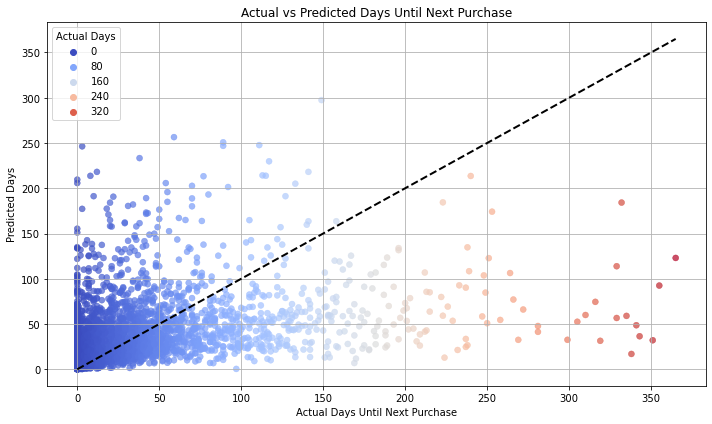

In [13]:
# Create a DataFrame for plotting
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='Actual', y='Predicted', hue='Actual',
                palette='coolwarm', alpha=0.7, edgecolor=None)

# Reference line (Perfect prediction line)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.title('Actual vs Predicted Days Until Next Purchase')
plt.xlabel('Actual Days Until Next Purchase')
plt.ylabel('Predicted Days')
plt.legend(title="Actual Days", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
Predict Next Purchase for New Customers
Take the most recent purchase of each active customer and feed their RFM-style features into the model.


In [11]:
latest_invoices = df_invoice.sort_values('InvoiceDate').groupby('CustomerID').tail(1)

X_latest = latest_invoices[features]
latest_invoices['PredictedDaysToNextPurchase'] = rf.predict(X_latest)

# Display predictions
latest_invoices[['CustomerID', 'InvoiceDate', 'PredictedDaysToNextPurchase']].head()


,CustomerID,InvoiceDate,PredictedDaysToNextPurchase
17919,18074.0,2010-12-01 09:53:00,133.88
4525,13747.0,2010-12-01 10:37:00,11.37
1622,12791.0,2010-12-01 11:27:00,65.67
17468,17908.0,2010-12-01 11:45:00,120.18
13254,16583.0,2010-12-01 12:03:00,80.01


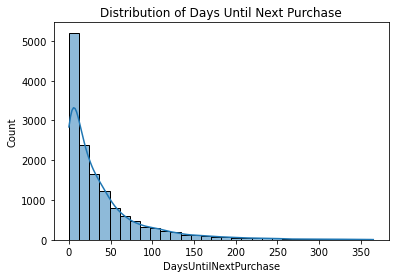

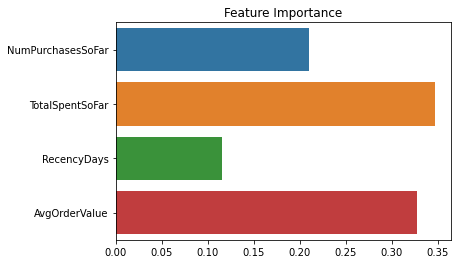

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_model['DaysUntilNextPurchase'], bins=30, kde=True)
plt.title("Distribution of Days Until Next Purchase")
plt.show()

# Feature importance
importances = rf.feature_importances_
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()
